In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import xarray as xr
import sys
import os
from re import split
import cartopy.crs as ccrs
import cartopy
import cartopy.mpl.ticker as cticker
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
from metpy.calc import pressure_to_height_std as p2h
from metpy.units import units

sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import get_pars_from_ini, make_dir

location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(file_name='loc')[location]['path_data']

In [4]:
cluster = SLURMCluster(queue="seseml",
                       memory='40GB',
                       cores=40,
                       processes=1,
                       walltime='23:40:00',
                       # scheduler_options={'host': '172.22.179.3:7227', 'dashboard_address': ':7798'}
                      )

In [5]:
# cluster.scale(2)
cluster.adapt(maximum_jobs=4)
cluster

In [6]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.22.179.101:36929,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [86]:
df_lear = pd.read_pickle(f"{path_data}/cloud_probes/pkl/Page0_Learjet.pkl")
df_lear['alt'] = df_lear.Palt * 0.3042 / 1000
df_lear = df_lear[(df_lear.alt > 0)]

In [92]:
df_p3b = pd.read_pickle(f"{path_data}/cloud_probes/pkl/p3b_merge.pkl")
df_p3b = df_p3b.rename(columns={" Latitude_YANG_MetNav":'Lat', " Longitude_YANG_MetNav":'Lon', " GPS_Altitude_YANG_MetNav":"Alt"})

In [102]:
min_lat = df_lear.Lat.min()
max_lat = df_lear.Lat.max()
min_lon = df_lear.Long[df_lear.Long > 0].min()
max_lon = df_lear.Long[df_lear.Long > 0].max()
image_extent = [int(min_lon-1), int(max_lon+1), int(min_lat-1), int(max_lat+1)]

In [103]:
image_extent

[117, 128, 12, 20]

In [94]:
image_extent

[115, 129, 5, 23]

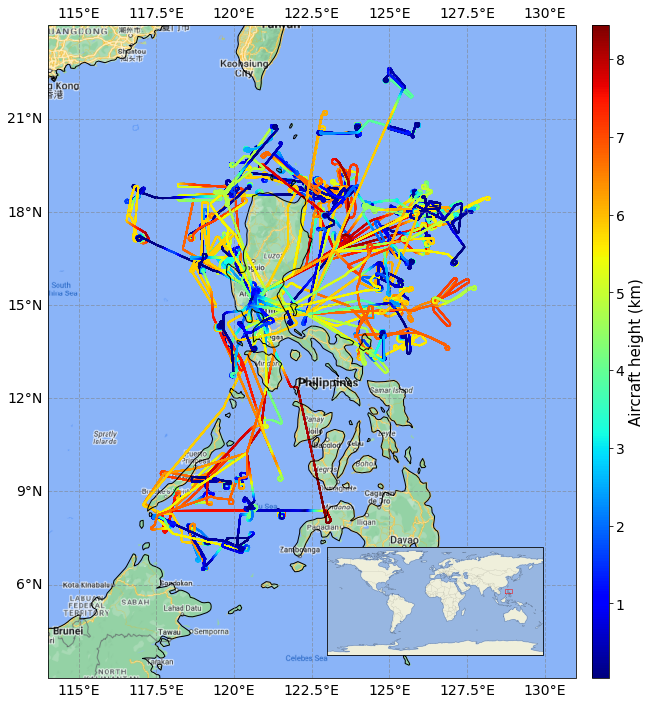

In [111]:
plt.rcParams.update({'font.size': 14})
axis_font = {'size':'15'}

fig = plt.figure(figsize=(15,12))
request = cimgt.GoogleTiles()
# request = cimgt.GoogleWTS()
# request = cimgt.OSM()
projection = ccrs.PlateCarree()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([114, 131, 3, 24])
ax.coastlines()
ax.add_image(request, 6)
# ax.gridlines(draw_labels=True, rasterized=True)
bmap = ax.scatter(df_lear.Long, df_lear.Lat, c=df_lear.alt, transform=ccrs.PlateCarree(), cmap='jet', s=0.5)
bmap = ax.scatter(df_p3b.Lon, df_p3b.Lat, c=df_p3b.Alt / 1000, transform=ccrs.PlateCarree(), cmap='jet', s=0.5)

clb = plt.colorbar(bmap, aspect=40, pad=0.02)
clb.set_label('Aircraft height (km)', **axis_font)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
# gl.xlabels_top = False
gl.right_labels = False

posn = ax.get_position()

# Map window
mp_left, mp_bottom, mp_width, mp_height = posn.x1 - 0.23, posn.y1 * 0.13, 0.2, 0.2
rect_mp = [mp_left, mp_bottom, mp_width, mp_height]
ax1 = fig.add_axes(rect_mp, projection=projection, zorder=0)
ax1.set_extent((-180, 180, -90, 90))
ax1.coastlines(linewidth=0.1)
ax1.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5, linewidth=0.1)
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.OCEAN)
lon0, lon1, lat0, lat1 = image_extent
box_x = [lon0, lon1, lon1, lon0, lon0]
box_y = [lat0, lat0, lat1, lat1, lat0]
ax1.plot(box_x, box_y, color='red', transform=ccrs.Geodetic(), linewidth=0.5)

fig.savefig('../results/df_filtered/map.jpg', bbox_inches="tight", dpi=300)

In [7]:
df = pd.read_csv('../results/all_filtered_202111111947.csv')
df.rename(columns={'Unnamed: 0': 'time'}, inplace=True)
df['time'] = pd.to_datetime(df.time)
df.index = df.time
df.drop(columns='time', inplace=True)

In [9]:
times = list(df.index)

In [24]:
ds_vel_pos = ds_xr.vel14.sel(time=times).where(ds_xr.vel14 > 0)
ds_vel_neg = ds_xr.vel14.sel(time=times).where(ds_xr.vel14 <= 0)

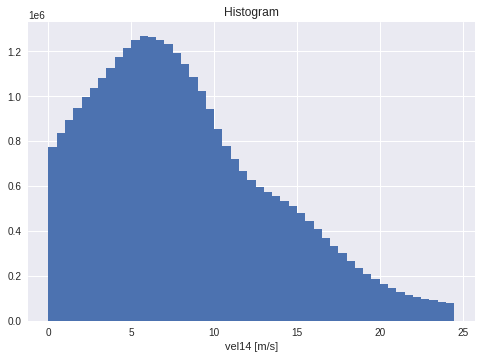

In [26]:
hist_14 = xr.plot.hist(ds_vel_pos,bins=np.arange(0, 25, .5))

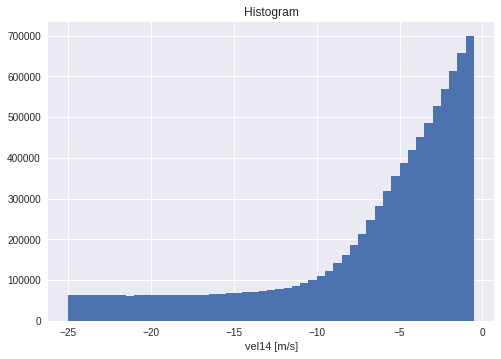

In [28]:
hist_14_neg = xr.plot.hist(ds_vel_neg,bins=np.arange(-25, 0, .5))

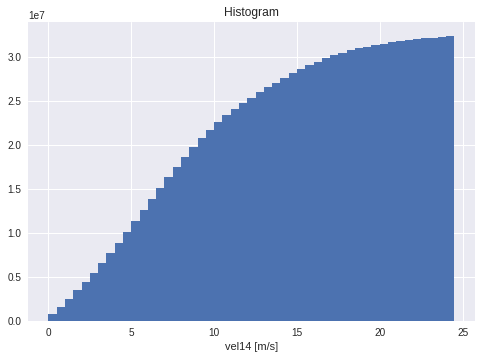

In [29]:
cum_14 = xr.plot.hist(ds_vel_pos,bins=np.arange(0, 25, .5), cumulative=True)